<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
</center>
<center>Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий

# <center>  Capstone проект №1. Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 3. Визуальный анализ данных и построение признаков

На 3 неделе мы займемся визуальным анализом данных и построением признаков. Сначала мы вместе построим и проанализируем несколько признаков, потом Вы сможете сами придумать и описать различные признаки. Задание имеет вид Peer-Review, так что творчество здесь активно приветствуется. Если задействуете IPython-виджеты, библиотеку Plotly, анимации и прочий интерактив, всем от этого будет только лучше.

**План 3 недели:**
 - Часть 1. Построение признаков
 - Часть 2. Визуальный анализ данных
 - Часть 3. Дальнейшее построение признаков
 - Часть 4. Проверка построенных признаков

**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Поиск структуры в данных":**
   - [Задача визуализации](https://www.coursera.org/learn/unsupervised-learning/lecture/hlvlT/zadacha-vizualizatsii)
   - [Визуализация данных в sklearn](https://www.coursera.org/learn/unsupervised-learning/lecture/ityMo/vizualizatsiia-dannykh-v-sklearn)
   
**Также в задании будет использоваться библиотека Seaborn (ее можно дополнительно установить командой *pip install seaborn*), будет полезно обращаться к документациям [Matplotlib](http://matplotlib.org/users/) и [Seaborn](http://seaborn.pydata.org/), а также к примерам визуализации, описанным на StackOverflow.**



## Часть 1. Построение признаков

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 25)
import pickle
#pip install seaborn
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt

import time

In [2]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = ('C:\Users\M\MFTIProjects2.7\user_behavior')

**Создайте на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, (от "feature engineering"), создайте следующие признаки:**
- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- `#unique_sites` – число уникальных сайтов в сессии 
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый DataFrame (как возвращала функция *prepare_train_set*), только признаков должно быть на 4 больше. Порядок, в котором добавляются признаки: *site1*, ... *site10*, *session_timespan*, *#unique_sites*, *start_hour*, *day_of_week* и *user_id* (это видно и чуть ниже по тому, как функция вызывается).

In [3]:
def prepare_train_set_with_fe(name, site_freq_path, feature_names=['session_timespan', 'unique_sites', 'start_hour', 'day_of_week', 'target'], session_length=10, window_size=10):
    PATH_TO_DATA = 'C:\Users\M\MFTIProjects2.7\user_behavior'
    file_list = [x[-12:] for x in glob(name + '\*.csv')]
    data = []
#    time_data = []
#создаем массив сессий, нарезанный по длине сессии и по размеру окна
    for i in range(len(file_list)):
        user_data = pd.read_csv(os.path.join(PATH_TO_DATA, name, file_list[i]))
        oneuser_sites = np.asarray(user_data.site)
        oneuser_times = np.array(user_data.timestamp, dtype=np.datetime64)
        diff_t = np.diff(oneuser_times).astype(int)
        mod = len(oneuser_sites) % session_length
        if mod != 0:
            oversamp = ((len(oneuser_sites) // session_length) + 1) * session_length - len(oneuser_sites)
            oneuser_sites = np.append(oneuser_sites, np.zeros(oversamp, dtype=int))
#            oneuser_times = np.append(oneuser_times, np.zeros(oversamp, dtype='datetime[s]'))  
        column_names = ['site'+ str(x) for x in range(session_length+1)[1:]]
        diff_column_names = ['diff_time'+ str(x) for x in range(session_length)[1:]]
#изменение количества сессий по ширине окна
        if window_size > session_length:
            print("eto isklyu4eno")
            break
        elif window_size == session_length:
            sess_array = oneuser_sites.reshape(len(oneuser_sites) // session_length, session_length)
            unique_sites_counts = [len(np.unique(x[x!=0])) for x in sess_array]
            idx = [x * session_length for x in range(sess_array.shape[0])]
            session_start_hour = [x.astype(object).hour for x in np.take(oneuser_times, idx)]
            session_start_weekday = [x.astype(object).weekday() for x in np.take(oneuser_times, idx)]
            user_sessions = pd.DataFrame(sess_array, columns=column_names)
            idx_to_drop = [x * session_length - 1 for x in range(user_sessions.shape[0]+1)[1:]]
            new_diff = np.delete(diff_t, idx_to_drop)
            if mod != 0:
                new_diff = np.append(new_diff, np.zeros(oversamp, dtype=int))
            diff_t = pd.DataFrame(new_diff.reshape(len(oneuser_sites) // session_length, session_length - 1), columns=diff_column_names)
# для разной ширины окна не проработал еще    
#        else:
#            windowed_array = np.array([])
#            left_bound = 0
#            while left_bound < len(oneuser_sites):
#                if left_bound+session_length >= len(oneuser_sites):
#                    windowed_session = np.append(oneuser_sites[left_bound:], np.zeros(shape=(session_length - len(oneuser_sites[left_bound:]))))
#                else:
#                   windowed_session = oneuser_sites[left_bound:left_bound+session_length]
#                windowed_array = np.append(windowed_array, windowed_session)
#                left_bound += window_size
#            user_sessions = pd.DataFrame(windowed_array.reshape(len(windowed_array) // session_length, session_length), columns=column_names)
        user_sessions = user_sessions.loc[(user_sessions != 0).any(axis=1)] #удаляем нулевые сессии
        diff_t = diff_t.loc[(diff_t != 0).any(axis=1)]
        user_sessions = user_sessions.join(diff_t)
        if 'session_timespan' in feature_names:
            user_sessions['session_timespan'] = user_sessions[diff_column_names].sum(axis=1)
        if 'unique_sites' in feature_names:
            user_sessions['unique_sites'] = unique_sites_counts
        if 'start_hour' in feature_names:
            user_sessions['start_hour'] = session_start_hour
        if 'day_of_week' in feature_names:
            user_sessions['day_of_week'] = session_start_weekday
        if 'target' in feature_names:
            user_sessions['target'] = int(file_list[i][-8:-4])
        data.append(user_sessions)

    all_sessions = pd.concat(data)
# открываем словарь
    with open(os.path.join(PATH_TO_DATA, site_freq_path), 'rb') as input_file:
        freq_dict = pickle.load(input_file)
# меняем все значения в массиве сессий по словарю
    for col in column_names:
        all_sessions[col] = all_sessions[col].apply(lambda x: int(x) if x == 0 else int(freq_dict.get(x,x)[0]))
        all_sessions.drop_duplicates(inplace=True)
    return all_sessions

In [4]:
X  = prepare_train_set_with_fe('3users', 'site_freq_3users.pkl', session_length=10, window_size=10)

In [5]:
X

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,diff_time1,diff_time2,diff_time3,diff_time4,diff_time5,diff_time6,diff_time7,diff_time8,diff_time9,session_timespan,unique_sites,start_hour,day_of_week,target
0,3,2,2,7,2,1,10,6,9,8,287,1184,6278,186,2,1,2,3,55,7998,8,9,4,1
1,3,1,1,1,0,0,0,0,0,0,2,3,55,0,0,0,0,0,0,60,2,12,4,1
0,3,2,5,5,2,0,0,0,0,0,287,1184,6278,186,0,0,0,0,0,7935,3,9,4,2
0,4,1,2,1,2,1,1,6,11,4,287,1184,6278,186,2,1,2,3,55,7998,5,9,4,3
1,4,1,2,0,0,0,0,0,0,0,287,1184,0,0,0,0,0,0,0,1471,3,12,4,3


**Проверим функцию на игрушечном примере.**

In [4]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']
train_data_toy  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '3users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_3users.pkl'),
                  feature_names=feature_names, session_length=10)

In [5]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,3,2,2,7,2,1,8,5,9,10,287,1184,6278,186,2,1,2,3,55,7998,8,9,4,1
1,3,1,1,1,0,0,0,0,0,0,2,3,55,0,0,0,0,0,0,60,2,12,4,1
2,3,2,6,6,2,0,0,0,0,0,287,1184,6278,186,0,0,0,0,0,7935,3,9,4,2
3,4,1,2,1,2,1,1,5,11,4,287,1184,6278,186,2,1,2,3,55,7998,5,9,4,3
4,4,1,2,0,0,0,0,0,0,0,287,1184,0,0,0,0,0,0,0,1471,3,12,4,3


**Примените функцию *prepare_train_set_with_fe* к данным по 10 пользователям, укажите *session_length*=10.**

In [6]:
%%time
train_data_10users = prepare_train_set_with_fe('10users', 'site_freq_10users.pkl', session_length=10, window_size=10)

Wall time: 4.61 s


In [7]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,diff_time1,diff_time2,diff_time3,diff_time4,diff_time5,diff_time6,diff_time7,diff_time8,diff_time9,session_timespan,unique_sites,start_hour,day_of_week,target
0,192,577,133,2,133,133,2,133,202,133,10.0,0.0,0.0,1.0,20.0,1.0,0.0,1.0,0.0,33.0,5,8,4,31
1,423,191,696,253,133,30,398,4208,217,54,1.0,0.0,163.0,105.0,0.0,1.0,3.0,3.0,8.0,284.0,10,8,4,31
2,54,2,54,54,4,293,423,335,935,54,0.0,14.0,1.0,242.0,0.0,0.0,1.0,0.0,0.0,258.0,7,8,4,31
3,475,4040,475,54,54,54,54,952,198,123,2.0,1.0,0.0,1.0,25.0,1.0,0.0,0.0,0.0,30.0,6,8,4,31
4,348,54,4,3380,258,211,4633,2208,680,2208,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,6.0,9,8,4,31


**Примените функцию *prepare_train_set_with_fe* к данным по 150 пользователям, укажите *session_length*=10.**

In [8]:
%%time
train_data_150users = prepare_train_set_with_fe('150users', 'site_freq_150users.pkl', session_length=10, window_size=10)

Wall time: 46 s


**Сохраните в pickle-файлы признаки *session_timespan*, *#unique_sites*, *start_hour* и *day_of_week* для 10 и 150 пользователей.**

In [9]:
new_features_10users = train_data_10users.iloc[:, -5 :-1].values
new_features_150users = train_data_150users.iloc[:, -5 :-1].values

In [10]:
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

## Часть 2. Визуальный анализ данных

**Забавы ради, потехи для дадим пользователям имена и ассоциируем с ними цвета.**

In [11]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
train_data_10users['target'] = train_data_10users['target'].map(id_name_dict)

In [12]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

**1. Постройте гистограмму распределения длины сессии в секундах (*session_timespan*). Ограничьте по *x* значением 200 (иначе слишком тяжелый хвост). Сделайте гистограмму цвета *darkviolet*, подпишите оси по-русски.**

Text(0,0.5,u'\u043a\u043e\u043b\u0438\u0447\u0435\u0441\u0442\u0432\u043e \u0441\u0435\u0441\u0441\u0438\u0439')

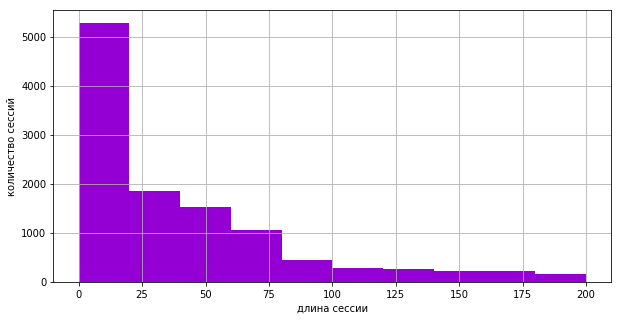

In [13]:
ax = train_data_10users[train_data_10users['session_timespan'] <= 200].session_timespan.hist(color='darkviolet', figsize=(10, 5))
ax.set_xlabel(u'длина сессии')
ax.set_ylabel(u'количество сессий')

**2. Постройте гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*). Сделайте гистограмму цвета *aqua*, подпишите оси по-русски.**

Text(0,0.5,u'\u043a\u043e\u043b\u0438\u0447\u0435\u0441\u0442\u0432\u043e \u0441\u0435\u0441\u0441\u0438\u0439')

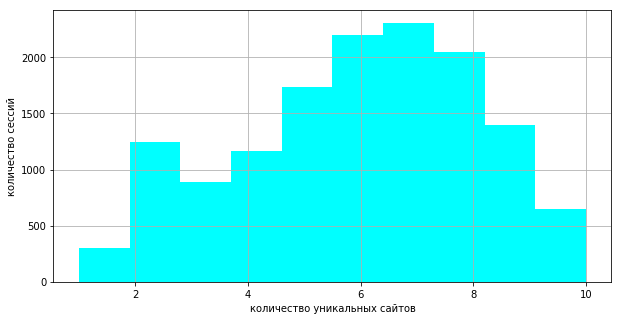

In [14]:
ax = train_data_10users['unique_sites'].hist(color='aqua', figsize=(10, 5))
ax.set_xlabel(u'количество уникальных сайтов')
ax.set_ylabel(u'количество сессий')

**3. Постройте гистограммы распределения числа уникальных сайтов в сессии (*#unique_sites*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

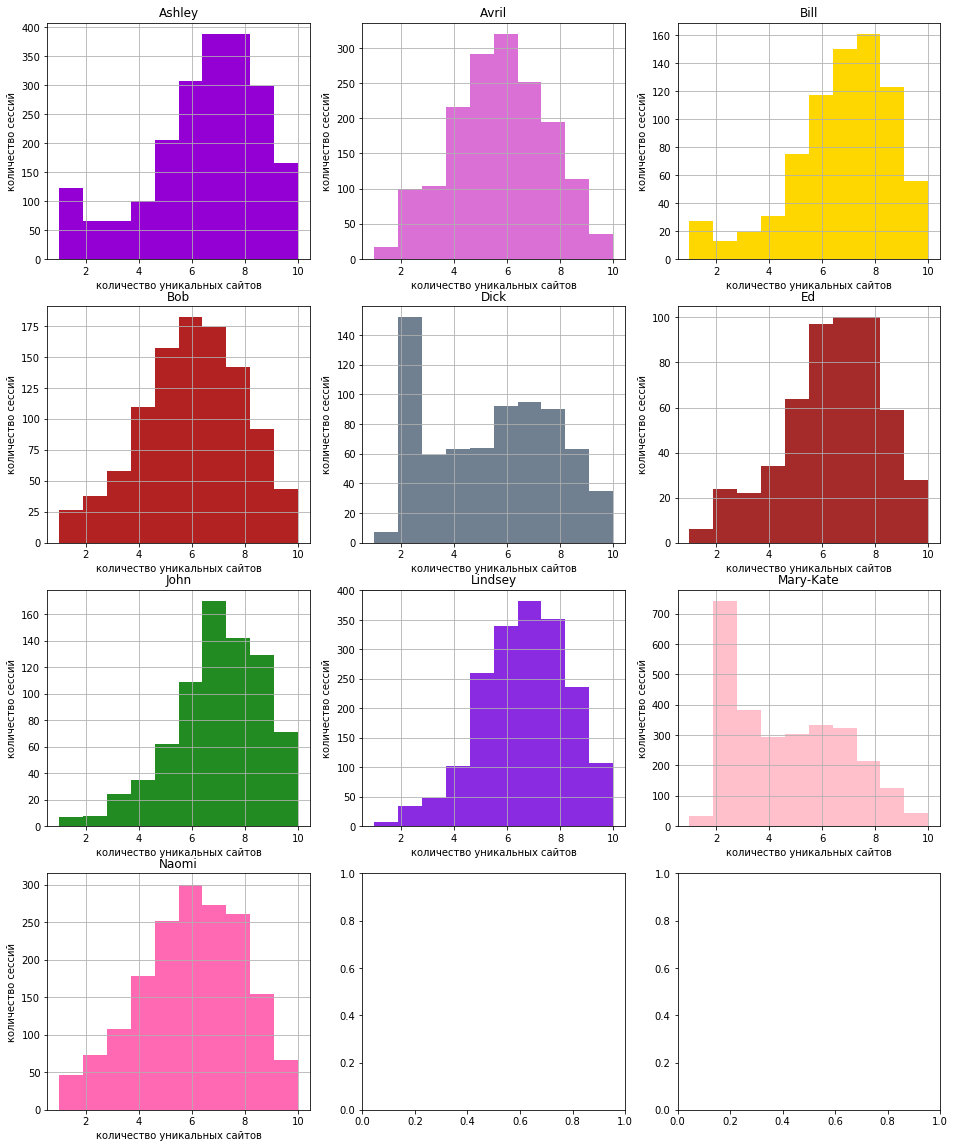

In [15]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(16, 20), )

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'target')):
    plt.subplot(4, 3, idx+1)
    ax = sub_df.unique_sites.hist(color=color_dic[user])
    ax.set_title(user)
    ax.set_xlabel(u'количество уникальных сайтов')
    ax.set_ylabel(u'количество сессий')

**4. Постройте гистограмму распределения часа начала сессии (*start_hour*). Сделайте гистограмму цвета *darkgreen*, подпишите оси по-русски.**

Text(0,0.5,u'\u043a\u043e\u043b\u0438\u0447\u0435\u0441\u0442\u0432\u043e \u0441\u0435\u0441\u0441\u0438\u0439')

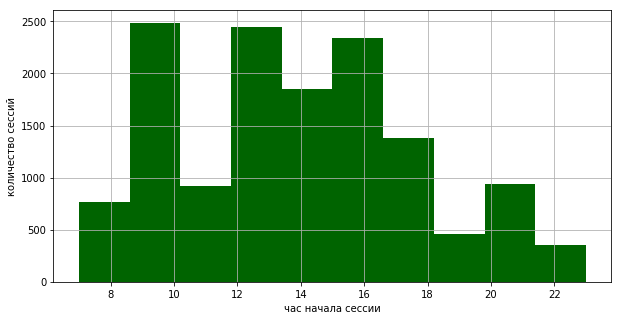

In [16]:
ax = train_data_10users['start_hour'].hist(color='darkgreen', figsize=(10,5))
ax.set_xlabel(u'час начала сессии')
ax.set_ylabel(u'количество сессий')

**5. Постройте гистограммы распределения часа начала сессии (*start_hour*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

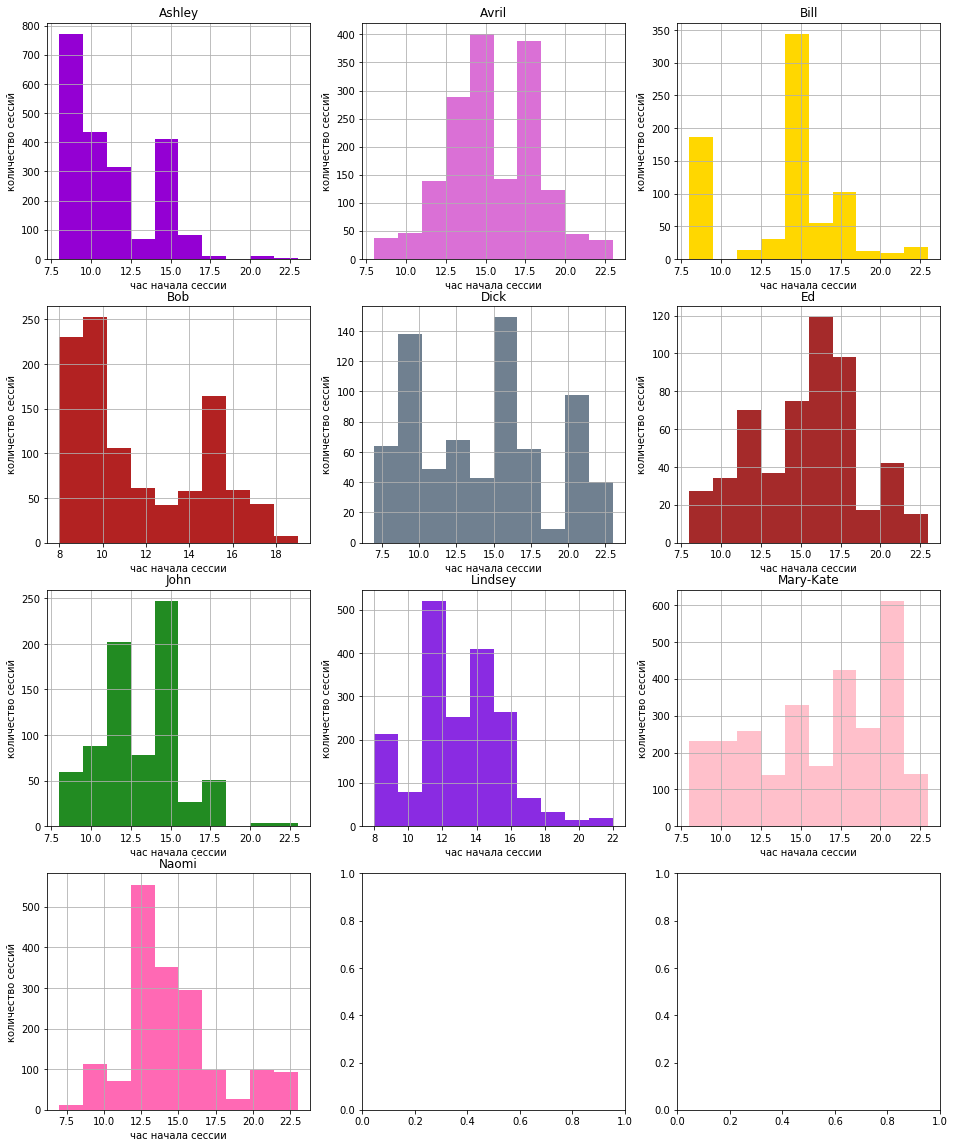

In [17]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(16, 20))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'target')):
    plt.subplot(4, 3, idx+1)
    ax = sub_df.start_hour.hist(color=color_dic[user])
    ax.set_title(user)
    ax.set_xlabel(u'час начала сессии')
    ax.set_ylabel(u'количество сессий')

**6. Постройте гистограмму распределения дня недели, в который началась сессия (*day_of_week*). Сделайте гистограмму цвета *sienna*, подпишите оси по-русски.**

Text(0,0.5,u'\u043a\u043e\u043b\u0438\u0447\u0435\u0441\u0442\u0432\u043e \u0441\u0435\u0441\u0441\u0438\u0439')

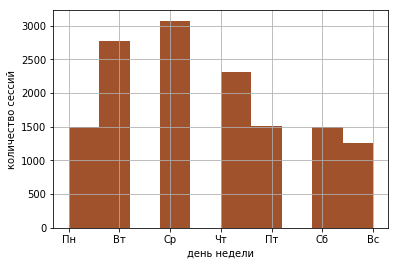

In [18]:
ax = train_data_10users['day_of_week'].hist(color='sienna')
ax.set_xticklabels([0, u'Пн', u'Вт', u'Ср', u'Чт', u'Пт', u'Сб', u'Вс'])
ax.set_xlabel(u'день недели')
ax.set_ylabel(u'количество сессий')

**7. Постройте гистограммы распределения дня недели, в который началась сессия (*day_of_week*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Измените метки по оси *X* на ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] – метод *set_xticklabels*. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите по-русски название каждой из 10 гистограмм.**

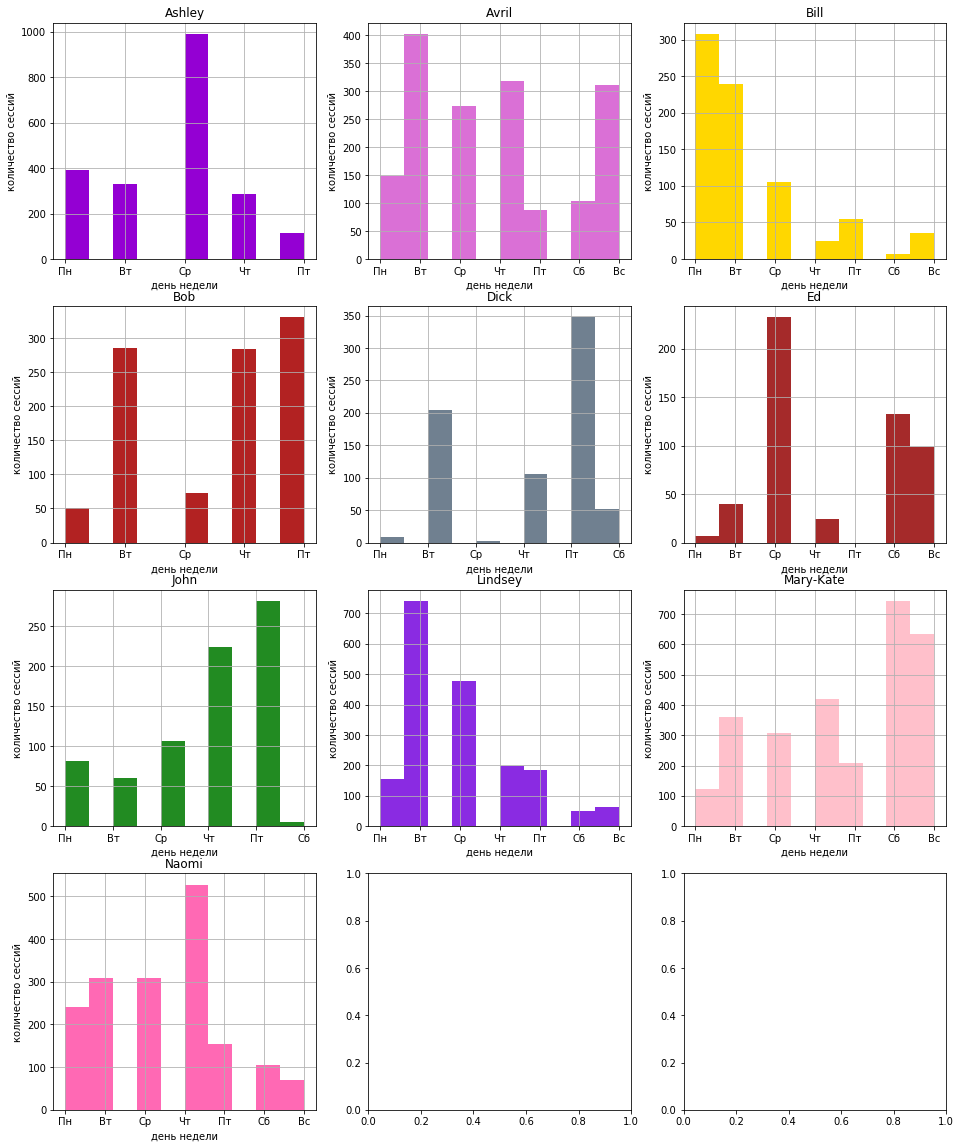

In [19]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(16, 20))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'target')):
    plt.subplot(4, 3, idx+1)
    ax = sub_df.day_of_week.hist(color=color_dic[user])
    ax.set_title(user)
    ax.set_xticklabels([0, u'Пн', u'Вт', u'Ср', u'Чт', u'Пт', u'Сб', u'Вс'])
    ax.set_xlabel(u'день недели')
    ax.set_ylabel(u'количество сессий')

**8. Сделайте выводы про каждого пользователя по построенным графикам.**

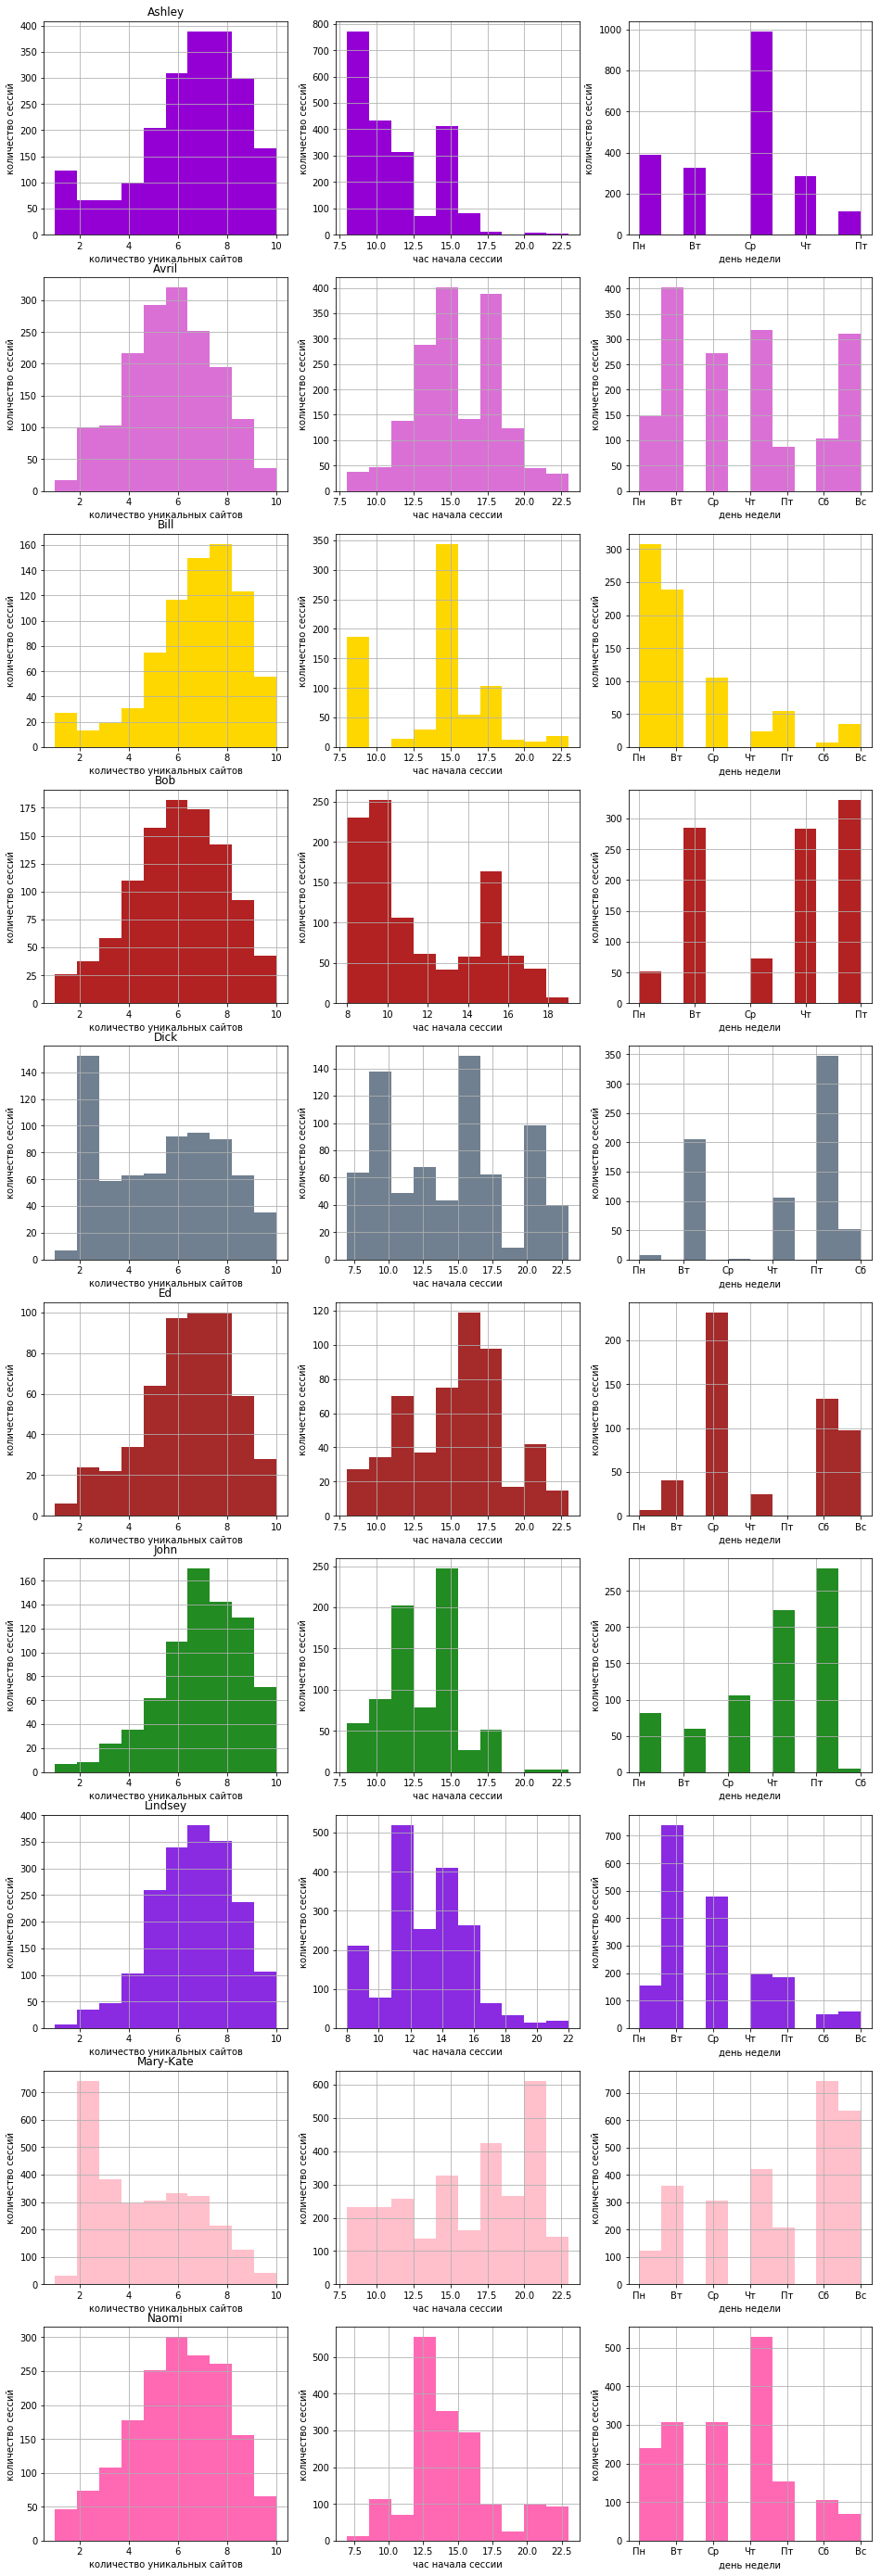

In [20]:
# чтобы удобно было делать выводы по каждому из пользователей

fig, axes = plt.subplots(nrows=10, ncols=3, figsize=(16, 50))

for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'target')):
    plt.subplot(10, 3, idx*3+1)
    ax = sub_df.unique_sites.hist(color=color_dic[user])
    ax.set_title(user)
    ax.set_xlabel(u'количество уникальных сайтов')
    ax.set_ylabel(u'количество сессий')
    
    plt.subplot(10, 3, idx*3+2)
    ax = sub_df.start_hour.hist(color=color_dic[user])
    ax.set_xlabel(u'час начала сессии')
    ax.set_ylabel(u'количество сессий')
    
    plt.subplot(10, 3, idx*3+3)
    ax = sub_df.day_of_week.hist(color=color_dic[user])
    ax.set_xticklabels([0, u'Пн', u'Вт', u'Ср', u'Чт', u'Пт', u'Сб', u'Вс'])
    ax.set_xlabel(u'день недели')
    ax.set_ylabel(u'количество сессий')

''' ВАШЕ ОПИСАНИЕ ЗДЕСЬ '''

* **Ashley**: чаще всего заходит в сеть рано утром и в 3 часа дня, преимущественно в среду, по выходным не заходит, сайты преимущественно различные.

* **Avril**: заходит в сеть в основном во вторник, среду, четверг и воскресенье, в 15 и 17:30, половина сайтов - как правило уникальные.

* **Bill**: заходит преимущественно на уникальные ресурсы. Рано утром и днем в 3 часа, в основном в понедельник и вторник. Редко заходит в выходные.

* **Bob**: 60% посещаемых сайтов уникальны. Заходит в основном рано утром и в 3 часа дня, после 7 вечера не заходит. Основные дни - вторник, четверг, пятница, по выходным не заходит.

* **Dick**: часто заходит на одни и те же ресурсы, в основном 9, 15 и 20 часов. Основные сессии - пятница, вторник, четверг, в воскресенье не заходит.

* **Ed**: сайты в основном уникальные. Пик посещений - с 4 до 5.30 дня, преимущественно в среду, немного в субботу и воскресенье, в пятницу не заходит.

* **John**: 70% посещаемых сайтов уникальны, заходит в основном в 12 и 15 часов, посещаемость растет от понедельника до пика в пятницу, в субботу почти не заходит, в воскресенье не заходит совсем.

* **Lindsey**: 70% посещаемых сайтов уникальны, заходит в основном в 12 и 2 часа дня, в основном во вторник и среду, по выходным заходит редко.

* **Mary-Kate** прекрасна своей постоянностью: преимущественно 2 сайта сессии уникальны!. Заходит в основном вечером, в 8, но каждый день, в выходные особенно часто.

* **Naomi**: 60% сайтов сессий уникальны, пик интернет-активности - 12:30, в основном в четверг.

**Загрузите сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей. **

In [21]:
freq_dict = pd.read_pickle(os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'))
freq_list = freq_dict.items()
freq_list.sort(key=lambda x: x[1][1], reverse=True)

**Определите топ-10 самых посещаемых сайтов (*top10_sites*) и соответствующие кол-ва посещений (*top10_freqs*).**

In [22]:
top10_freqs = [x[1][1] for x in freq_list[:10]]
top10_sites = [x[0] for x in freq_list[:10]]

In [23]:
print(top10_sites)
print(top10_freqs)

['s.youtube.com', 'www.google.fr', 'www.google.com', 'mail.google.com', 'www.facebook.com', 'apis.google.com', 'r3---sn-gxo5uxg-jqbe.googlevideo.com', 'r1---sn-gxo5uxg-jqbe.googlevideo.com', 'plus.google.com', 'accounts.google.com']
[8300, 7813, 5441, 4158, 4141, 3758, 3244, 3094, 2630, 2089]


**9. Нарисуйте *seaborn barplot*, показывающий частоты посещений топ-10 сайтов. Сделайте подписи сайтов вертикальными, иначе они сливаются (*xticks*).**

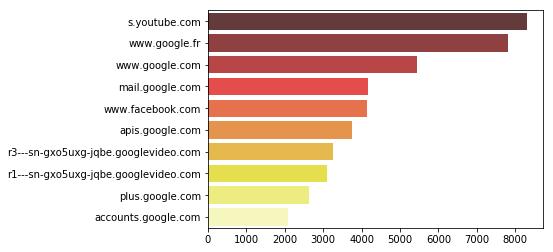

In [24]:
# так читаемость выше и подписи стали вертикальными сами собой)
sns.barplot(top10_freqs, top10_sites, alpha=0.8, palette="hot")

## Часть 3. Проверка построенных признаков
Эта часть скорее техническая, смысл ее – убедиться, что мы все одинаково создали признаки *session_timespan, #unique_sites, start_hour* и *day_of_week*.

**10. Выведите медианную продолжительность сессии (*session_timespan*) для сессий 10 пользователей.**

In [25]:
train_data_10users.session_timespan.median()

37.0

**11. Выведите медианный день недели, в который началась сессия, для сессий 10 пользователей.**

In [142]:
train_data_10users.day_of_week.median()

2.0

**12. Выведите медианный час начала сессии для сессий 150 пользователей.**

In [27]:
train_data_150users.start_hour.median()

13.0

**13. Выведите медианное значение числа уникальных сайтов в сессиях 150 пользователей.**

In [28]:
train_data_150users.unique_sites.median()

7.0

## Часть 4. Дальнейшее построение признаков

Это задание творческое, тут надо придумать, как еще учесть время посещения веб-страниц и прочие признаки. 

На следующей неделе мы будем использовать "мешок" сайтов  для классификации сессий по принадлежности разным пользователям, а эти новые признаки, которые Вы сейчас создадите, потом добавим и посмотрим, улучшается ли модель. Поэтому можно их создать в виде отдельных матриц и сохранить их также отдельно.  

В этой части задания Вы можете построить и визуально исследовать самые разные признаки (ничто фантазию не ограничивает):
- год, месяц и день начала сессии
- час начала сессии (с учетом года, месяца и дня)
- время суток
- среднее время пребывания на сайте, посчитать можно, скажем, для топ-30 популярных сайтов
- индикаторы посещения популярных сайтов (скажем, тоже для топ-30 популярных сайтов)
- частота посещения Facebook
- ...

**Напишите функцию для создания новых признаков и примените ее к исходным данным – каталогам с 10 и 150 файлами. Сделайте это только для набора данных, полученного с параметрами *session_length=10* и *window_size=10*. Сериализуйте полученные матрицы с помощью pickle. Функция может возвращать как только новые признаки, так и старые с новыми. При этом сигнатура функции может быть другой – тут уже свобода выбора.**

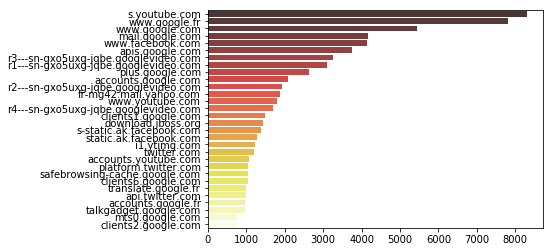

In [32]:
top30_freqs = [x[1][1] for x in freq_list[:30]]
top30_sites = [x[0] for x in freq_list[:30]]
sns.barplot(top30_freqs, top30_sites, alpha=0.8, palette="hot")

Добавлю, пожалуй, такие признаки:
- количество посещений google-страниц
- количество посещений facebook
- количество посещенний twitter
- количество практически одновременно открытых сайтов в одной сессии (diff_time < 2 секунд)
- количество посещений сайтов из топ-30

In [91]:
def prepare_train_set_with_fe(name, site_freq_path, feature_names=['session_timespan', 'unique_sites', 'start_hour', 'day_of_week',
                                                                   'google_visits', 'facebook_visits', 'twitter_visits',
                                                                   'simultaneous_sites_opened', 'top30_visits', 'target'], session_length=10, window_size=10):
    PATH_TO_DATA = 'C:\Users\M\MFTIProjects2.7\user_behavior'
    file_list = [x[-12:] for x in glob(name + '\*.csv')]
    data = []
#    time_data = []
#создаем массив сессий, нарезанный по длине сессии и по размеру окна
    for i in range(len(file_list)):
        user_data = pd.read_csv(os.path.join(PATH_TO_DATA, name, file_list[i]))
        oneuser_sites = np.asarray(user_data.site)
        oneuser_times = np.array(user_data.timestamp, dtype=np.datetime64)
        diff_t = np.diff(oneuser_times).astype(int)
        mod = len(oneuser_sites) % session_length
        if mod != 0:
            oversamp = ((len(oneuser_sites) // session_length) + 1) * session_length - len(oneuser_sites)
            oneuser_sites = np.append(oneuser_sites, np.zeros(oversamp, dtype=int))
#            oneuser_times = np.append(oneuser_times, np.zeros(oversamp, dtype='datetime[s]'))  
        column_names = ['site'+ str(x) for x in range(session_length+1)[1:]]
        diff_column_names = ['diff_time'+ str(x) for x in range(session_length)[1:]]
#изменение количества сессий по ширине окна
        if window_size > session_length:
            print("eto isklyu4eno")
            break
        elif window_size == session_length:
            sess_array = oneuser_sites.reshape(len(oneuser_sites) // session_length, session_length)
            unique_sites_counts = [len(np.unique(x[x!=0])) for x in sess_array]
            idx = [x * session_length for x in range(sess_array.shape[0])]
            session_start_hour = [x.astype(object).hour for x in np.take(oneuser_times, idx)]
            session_start_weekday = [x.astype(object).weekday() for x in np.take(oneuser_times, idx)]
            user_sessions = pd.DataFrame(sess_array, columns=column_names)
            idx_to_drop = [x * session_length - 1 for x in range(user_sessions.shape[0]+1)[1:]]
            new_diff = np.delete(diff_t, idx_to_drop)
            if mod != 0:
                new_diff = np.append(new_diff, np.zeros(oversamp, dtype=int))
            diff_t = pd.DataFrame(new_diff.reshape(len(oneuser_sites) // session_length, session_length - 1), columns=diff_column_names)
        user_sessions = user_sessions.loc[(user_sessions != 0).any(axis=1)] #удаляем нулевые сессии
        diff_t = diff_t.loc[(diff_t != 0).any(axis=1)]
        user_sessions = user_sessions.join(diff_t)
        if 'session_timespan' in feature_names:
            user_sessions['session_timespan'] = user_sessions[diff_column_names].sum(axis=1)
        if 'unique_sites' in feature_names:
            user_sessions['unique_sites'] = unique_sites_counts
        if 'start_hour' in feature_names:
            user_sessions['start_hour'] = session_start_hour
        if 'day_of_week' in feature_names:
            user_sessions['day_of_week'] = session_start_weekday
        if 'target' in feature_names:
            user_sessions['target'] = int(file_list[i][-8:-4])
        data.append(user_sessions)

    all_sessions = pd.concat(data)
    if 'google_visits' in feature_names:
        isGoogle = lambda x: 1 if type(x) is str and x.lower().find('google') > -1 else 0
        all_sessions['google_visits'] = all_sessions.apply(lambda row: isGoogle(row[column_names[0]])
                                                                            + isGoogle(row[column_names[1]])
                                                                            + isGoogle(row[column_names[2]])
                                                                            + isGoogle(row[column_names[3]])
                                                                            + isGoogle(row[column_names[4]])
                                                                            + isGoogle(row[column_names[5]])
                                                                            + isGoogle(row[column_names[6]])
                                                                            + isGoogle(row[column_names[7]])
                                                                            + isGoogle(row[column_names[8]])
                                                                            + isGoogle(row[column_names[9]]), axis=1)
    if 'facebook_visits' in feature_names:
        isFacebook = lambda x: 1 if type(x) is str and x.lower().find('facebook') > -1 else 0
        all_sessions['facebook_visits'] = all_sessions.apply(lambda row: isFacebook(row[column_names[0]])
                                                                            + isFacebook(row[column_names[1]])
                                                                            + isFacebook(row[column_names[2]])
                                                                            + isFacebook(row[column_names[3]])
                                                                            + isFacebook(row[column_names[4]])
                                                                            + isFacebook(row[column_names[5]])
                                                                            + isFacebook(row[column_names[6]])
                                                                            + isFacebook(row[column_names[7]])
                                                                            + isFacebook(row[column_names[8]])
                                                                            + isFacebook(row[column_names[9]]), axis=1)
    if 'twitter_visits' in feature_names:
        isTwitter = lambda x: 1 if type(x) is str and x.lower().find('twitter') > -1 else 0
        all_sessions['twitter_visits'] = all_sessions.apply(lambda row: isTwitter(row[column_names[0]])
                                                                            + isTwitter(row[column_names[1]])
                                                                            + isTwitter(row[column_names[2]])
                                                                            + isTwitter(row[column_names[3]])
                                                                            + isTwitter(row[column_names[4]])
                                                                            + isTwitter(row[column_names[5]])
                                                                            + isTwitter(row[column_names[6]])
                                                                            + isTwitter(row[column_names[7]])
                                                                            + isTwitter(row[column_names[8]])
                                                                            + isTwitter(row[column_names[9]]), axis=1)
    if 'simultaneous_sites_opened' in feature_names:
        isSimultanSiteOpen = lambda x: 1 if x < 2 else 0
        all_sessions['simultan_sites_opened'] = all_sessions.apply(lambda row: isSimultanSiteOpen(row[diff_column_names[0]])
                                                                            + isSimultanSiteOpen(row[diff_column_names[1]])
                                                                            + isSimultanSiteOpen(row[diff_column_names[2]])
                                                                            + isSimultanSiteOpen(row[diff_column_names[3]])
                                                                            + isSimultanSiteOpen(row[diff_column_names[4]])
                                                                            + isSimultanSiteOpen(row[diff_column_names[5]])
                                                                            + isSimultanSiteOpen(row[diff_column_names[6]])
                                                                            + isSimultanSiteOpen(row[diff_column_names[7]])
                                                                            + isSimultanSiteOpen(row[diff_column_names[8]]), axis=1)
# открываем словарь
    with open(os.path.join(PATH_TO_DATA, site_freq_path), 'rb') as input_file:
        freq_dict = pickle.load(input_file)
    
    if 'top30_visits' in feature_names:
        freq_list = freq_dict.items()
        freq_list.sort(key=lambda x: x[1][1], reverse=True)
        top30_sites = [x[0] for x in freq_list[:30]]
        isInTop30 = lambda x: 1 if x in top30_sites else 0
        all_sessions['top30_visits'] = all_sessions.apply(lambda row: isInTop30(row[sites[0]])
                                                                                + isInTop30(row[column_names[1]])
                                                                                + isInTop30(row[column_names[2]])
                                                                                + isInTop30(row[column_names[3]])
                                                                                + isInTop30(row[column_names[4]])
                                                                                + isInTop30(row[column_names[5]])
                                                                                + isInTop30(row[column_names[6]])
                                                                                + isInTop30(row[column_names[7]])
                                                                                + isInTop30(row[column_names[8]])
                                                                                + isInTop30(row[column_names[9]]), axis=1)
# меняем все значения в массиве сессий по словарю
    for col in column_names:
        all_sessions[col] = all_sessions[col].apply(lambda x: int(x) if x == 0 else int(freq_dict.get(x,x)[0]))
#        all_sessions.drop_duplicates(inplace=True)
    return all_sessions

In [124]:
%%time
train_data_10users_new_features = prepare_train_set_with_fe('10users', 'site_freq_10users.pkl', session_length=10, window_size=10)

Wall time: 13.9 s


In [100]:
train_data_10users_new_features.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,diff_time1,diff_time2,...,diff_time8,diff_time9,session_timespan,unique_sites,start_hour,day_of_week,target,google_visits,facebook_visits,twitter_visits,simultan_sites_opened,top30_visits
0,192,577,133,2,133,133,2,133,202,133,10.0,0.0,...,1.0,0.0,33.0,5,8,4,31,2,0,0,7,2
1,423,191,696,253,133,30,398,4208,217,54,1.0,0.0,...,3.0,8.0,284.0,10,8,4,31,1,0,0,4,0
2,54,2,54,54,4,293,423,335,935,54,0.0,14.0,...,0.0,0.0,258.0,7,8,4,31,1,1,0,7,2
3,475,4040,475,54,54,54,54,952,198,123,2.0,1.0,...,0.0,0.0,30.0,6,8,4,31,0,0,0,7,0
4,348,54,4,3380,258,211,4633,2208,680,2208,1.0,0.0,...,1.0,0.0,6.0,9,8,4,31,0,1,0,9,1


In [99]:
%%time
train_data_150users_new_features = prepare_train_set_with_fe('150users', 'site_freq_150users.pkl', session_length=10, window_size=10)

Wall time: 2min 33s


In [101]:
train_data_150users_new_features.head(10)

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,diff_time1,diff_time2,...,diff_time8,diff_time9,session_timespan,unique_sites,start_hour,day_of_week,target,google_visits,facebook_visits,twitter_visits,simultan_sites_opened,top30_visits
0,0,0,3,1,0,3,0,1,1291,321,1.0,1.0,...,49.0,0.0,57.0,5,8,4,6,8,0,0,7,8
1,1,22,1508,1291,321,321,112,72,48,48,0.0,0.0,...,1504.0,4.0,1618.0,8,8,4,6,2,0,0,4,2
2,321,204,0,0,0,0,72,321,1,0,1.0,10.0,...,0.0,4.0,2010.0,5,8,4,6,6,0,0,3,6
3,0,0,7147,7147,5555,7147,7147,0,34,0,1.0,0.0,...,6.0,0.0,2006.0,4,9,4,6,5,0,0,5,4
4,0,0,75,0,57,49,57,49,82,75,4.0,3.0,...,1.0,0.0,10.0,5,9,4,6,10,0,0,7,3
5,49,57,93,91,49,75,75,82,91,49,0.0,1.0,...,0.0,0.0,2.0,6,9,4,6,10,0,0,9,0
6,57,93,57,91,75,82,49,93,93,75,0.0,6.0,...,1.0,0.0,7.0,6,9,4,6,10,0,0,8,0
7,82,49,57,91,57,93,49,49,75,57,0.0,0.0,...,0.0,1.0,9.0,6,9,4,6,10,0,0,8,0
8,93,75,82,49,91,57,7147,75,49,57,0.0,0.0,...,1.0,0.0,835.0,7,9,4,6,9,0,0,8,0
9,93,91,75,57,49,91,93,49,57,82,0.0,0.0,...,0.0,0.0,1.0,6,9,4,6,10,0,0,9,0


In [107]:
cols = train_data_10users_new_features.columns.tolist()

In [125]:
train_data_10users_new_features.drop(train_data_10users_new_features[cols[:19]], axis=1, inplace=True)

In [116]:
train_data_10users_new_features.head()

,session_timespan,unique_sites,start_hour,day_of_week,target,google_visits,facebook_visits,twitter_visits,simultan_sites_opened,top30_visits
0,33.0,5,8,4,31,2,0,0,7,2
1,284.0,10,8,4,31,1,0,0,4,0
2,258.0,7,8,4,31,1,1,0,7,2
3,30.0,6,8,4,31,0,0,0,7,0
4,6.0,9,8,4,31,0,1,0,9,1


In [117]:
train_data_150users_new_features.drop(train_data_150users_new_features[cols[:19]], axis=1, inplace=True) 

In [118]:
train_data_150users_new_features.head()

,session_timespan,unique_sites,start_hour,day_of_week,target,google_visits,facebook_visits,twitter_visits,simultan_sites_opened,top30_visits
0,57.0,5,8,4,6,8,0,0,7,8
1,1618.0,8,8,4,6,2,0,0,4,2
2,2010.0,5,8,4,6,6,0,0,3,6
3,2006.0,4,9,4,6,5,0,0,5,4
4,10.0,5,9,4,6,10,0,0,7,3


**14. Постройте картинки для новых признаков, поисследуйте их, прокомментируйте результаты.**

In [126]:
train_data_10users_new_features['target'] = train_data_10users_new_features['target'].map(id_name_dict)

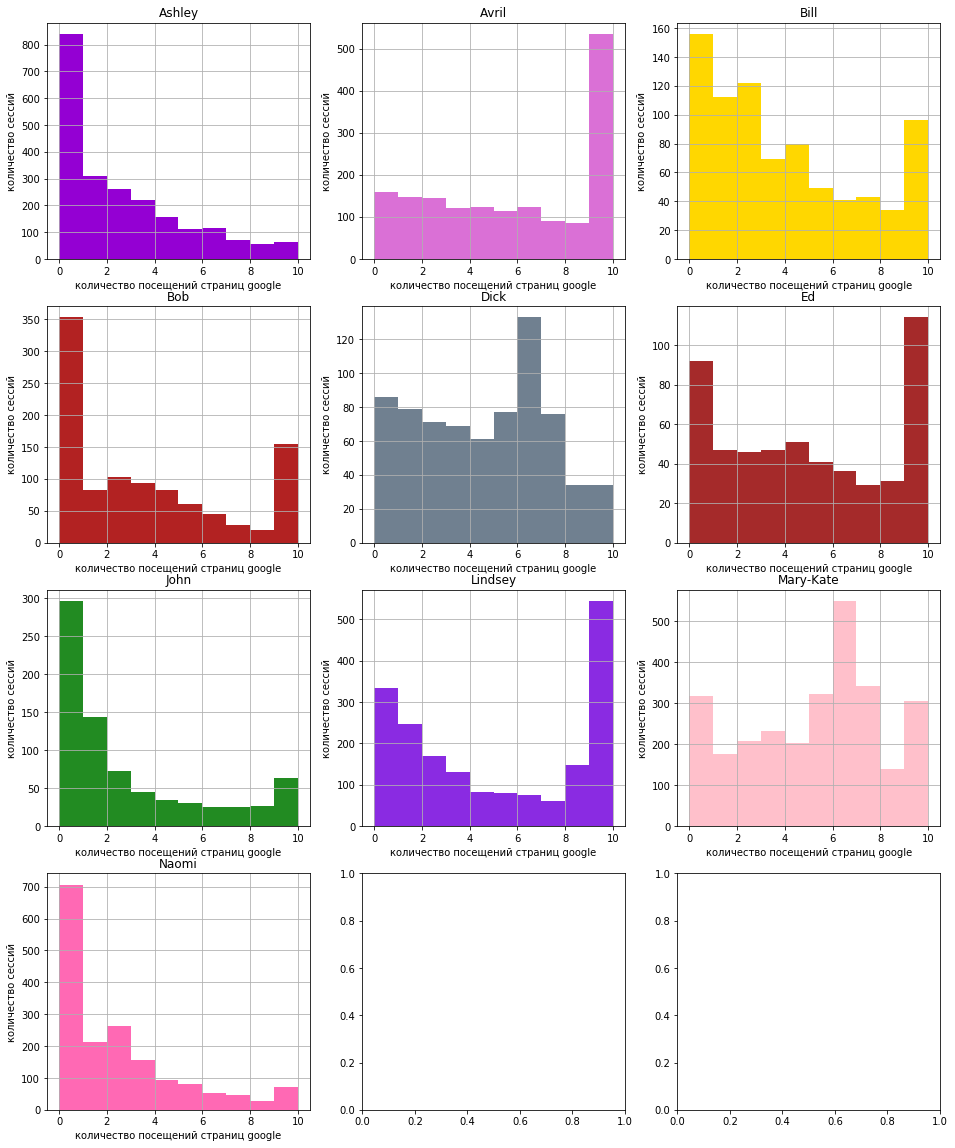

In [127]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(16, 20))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users_new_features, 'target')):
    plt.subplot(4, 3, idx+1)
    ax = sub_df.google_visits.hist(color=color_dic[user])
    ax.set_title(user)
    ax.set_xlabel(u'количество посещений страниц google')
    ax.set_ylabel(u'количество сессий')

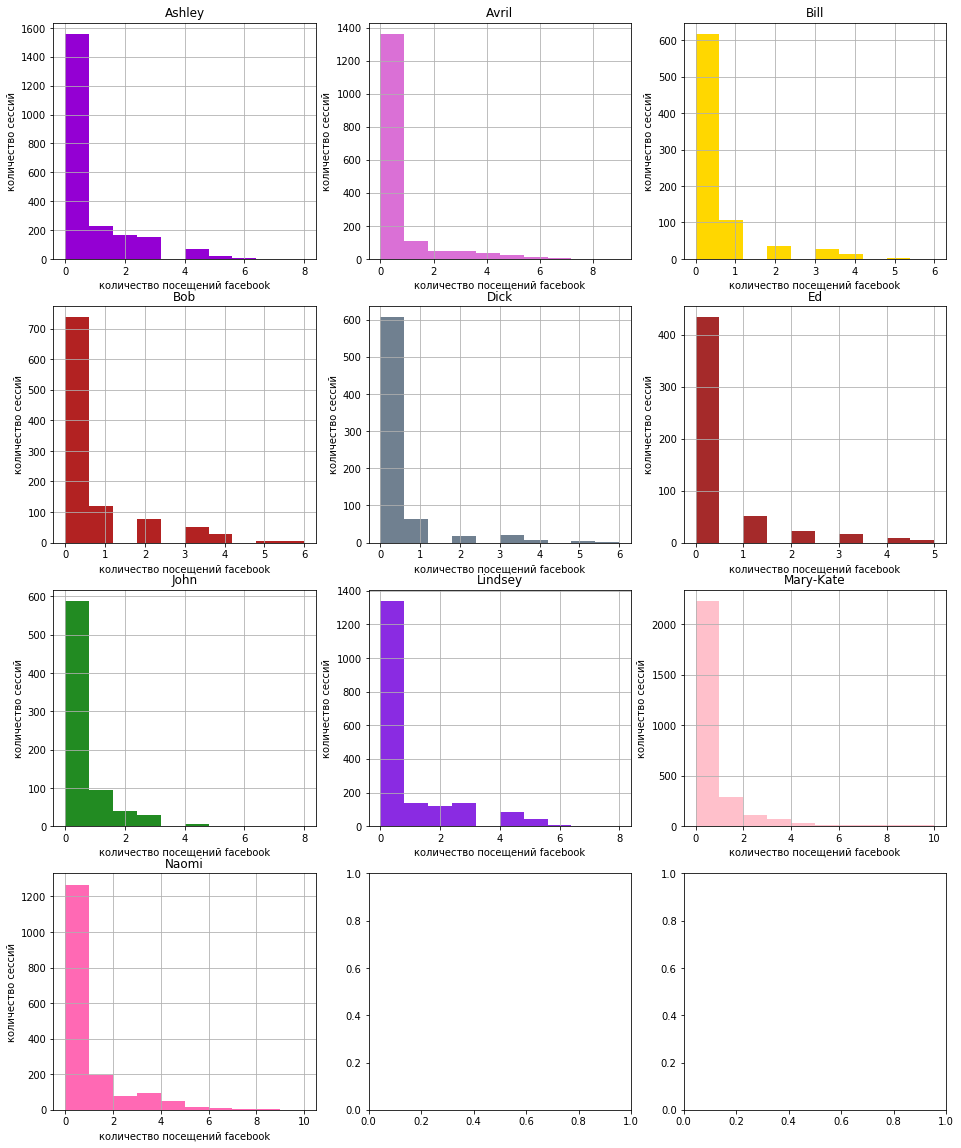

In [128]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(16, 20))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users_new_features, 'target')):
    plt.subplot(4, 3, idx+1)
    ax = sub_df.facebook_visits.hist(color=color_dic[user])
    ax.set_title(user)
    ax.set_xlabel(u'количество посещений facebook')
    ax.set_ylabel(u'количество сессий')

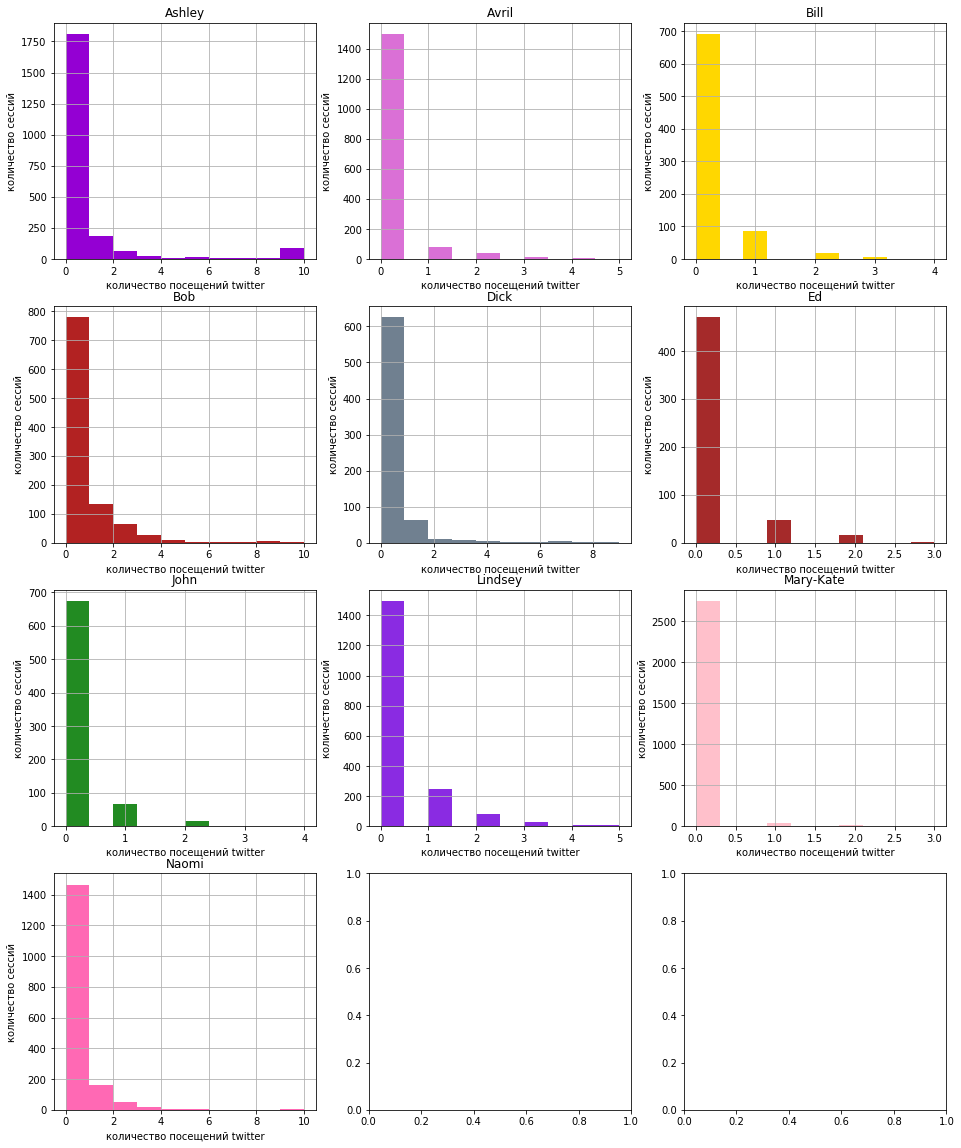

In [129]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(16, 20))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users_new_features, 'target')):
    plt.subplot(4, 3, idx+1)
    ax = sub_df.twitter_visits.hist(color=color_dic[user])
    ax.set_title(user)
    ax.set_xlabel(u'количество посещений twitter')
    ax.set_ylabel(u'количество сессий')

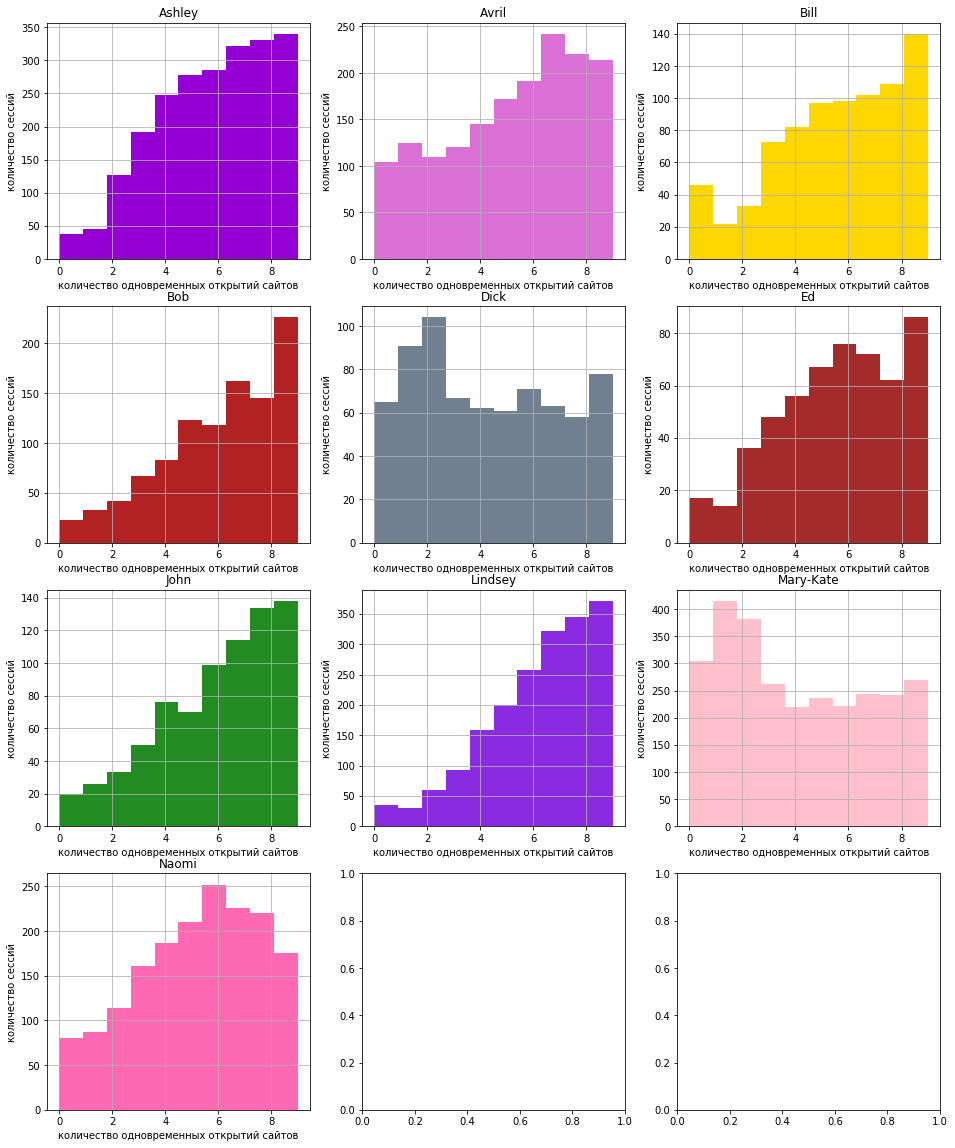

In [130]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(16, 20))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users_new_features, 'target')):
    plt.subplot(4, 3, idx+1)
    ax = sub_df.simultan_sites_opened.hist(color=color_dic[user])
    ax.set_title(user)
    ax.set_xlabel(u'количество одновременных открытий сайтов')
    ax.set_ylabel(u'количество сессий')

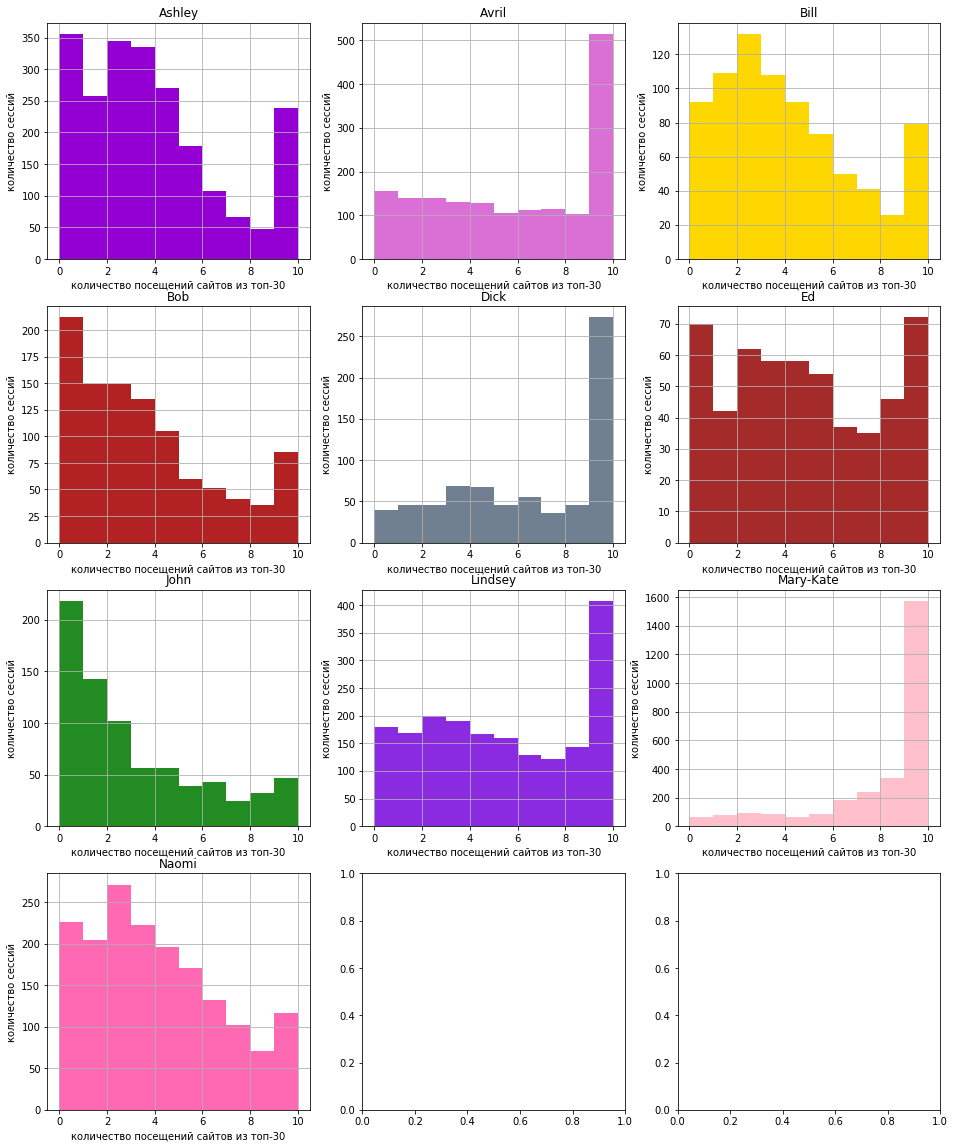

In [131]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(16, 20))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users_new_features, 'target')):
    plt.subplot(4, 3, idx+1)
    ax = sub_df.top30_visits.hist(color=color_dic[user])
    ax.set_title(user)
    ax.set_xlabel(u'количество посещений сайтов из топ-30')
    ax.set_ylabel(u'количество сессий')

Из созданных признаков признаки количества посещений facebook и twitter в сессии работают довольно плохо, зато все остальные:
количество посещений сайтов топ-30, количество посещений страниц google, количество одновременных открытий сайтов в сессии - на выборке из 10 пользователей выглядят достаточно репрезентативно. Их и возьмем.

**В конце сохраните в pickle-файлы только те признаки, которые, как Вы предполагаете, помогут идентифицировать пользователя более точно. Это касается и признаков, которые мы вместе создали в начале (*session_timespan, #unique_sites, start_hour, day_of_week*), и Ваших собственных. Можно создать все эти признаки не только для сессий из 10 сайтов, но и для других сочетаний параметров *session_length* и *window_size*.**

In [139]:
selected_features_10users = train_data_10users_new_features[['session_timespan', 'unique_sites', 'start_hour', 'day_of_week', 'google_visits', 'simultan_sites_opened', 'top30_visits']].copy()
selected_features_150users = train_data_150users_new_features[['session_timespan', 'unique_sites', 'start_hour', 'day_of_week', 'google_visits', 'simultan_sites_opened', 'top30_visits']].copy()

In [141]:
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_10users.pkl'), 'wb') as selected_features_10users_pkl:
    pickle.dump(selected_features_10users, selected_features_10users_pkl, 
                protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_150users.pkl'), 'wb') as selected_features_150users_pkl:
    pickle.dump(selected_features_150users, selected_features_150users_pkl, 
                protocol=2)

## Критерии оценки работы:
- Верно ли отображена гистограмма session_timespan из п. 1? (max. 3 балла)
- Верно ли отображена гистограмма #unique_sites из п. 2? (max. 3 балла)
- Верно ли отображены гистограммы #unique_sites по каждому пользователю из п. 3? (max. 6 баллов)
- Верно ли отображена гистограмма start_hour из п. 4? (max. 3 балла)
- Верно ли отображены гистограммы start_hour по каждому пользователю из п. 5? (max. 6 баллов)
- Верно ли отображена гистограмма day_of_week из п. 6? (max. 3 балла)
- Верно ли отображены гистограммы day_of_week по каждому пользователю из п. 7? (max. 6 баллов)
- Насколько сделанные выводы в п. 8 соответствуют построенным картинкам? (max. 6 баллов)
- Верно ли отображен barplot для 10 популярных сайтов из п. 9? (max. 6 баллов)
- Правильно ли посчитана медианная продолжительность сессий в п. 10? (max. 3 балла)
- Правильно ли посчитан медианный день недели начала сессии в п. 11? (max. 3 балла)
- Правильно ли посчитан медианный час начала сессии в п. 12? (max. 3 балла)
- Правильно ли посчитано медианное значение числа уникальных сайтов в сессиях 150 пользователей п. 13? (max. 3 балла)
- Есть ли оригинальные построенные признаки и картинки к ним? Оцените также и качество картинок. (max. 8 баллов)

## Пути улучшения
7 неделя посвящена общему описанию проекта (`html`, `ipynb` или `pdf`) и взаимному оцениванию. Что еще можно добавить по 3 части проекта:
- IPython-widgets, интерактив и анимация (стоящие статьи по этому ремеслу – [раз](https://habrahabr.ru/post/308162/) и  [два](https://habrahabr.ru/company/ods/blog/323210/))
- можно попробовать изобразить исходные данные в некотором пространстве, например, Word2Vec, потом выделить главные компоненты или t-SNE  (только пользуйтесь эффективными реализациями типа [Multicore-TSNE](https://github.com/DmitryUlyanov/Multicore-TSNE), не Sklearn) и раскрасить по целевому классу. Но нет гарантий, что получится что-то значимо отличающееся от каши

На следующей неделе мы наконец приступим к обучению моделей классификации. 